In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import joblib

In [3]:
import sys
sys.path.append("../scripts/")
from utils import plot_confusion_matrix, print_metrics

In [4]:
# Get Data
data_path = '../data/with_features/'
train_data = pd.read_csv(f'{data_path}train.csv')
test_data = pd.read_csv(f'{data_path}test.csv')

## `Human vs Generation`

In [5]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']

# Keep only human and generation labels
Z_train = train_data[train_data['label'].isin(['human', 'generation'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'generation'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'generation': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'generation': 1})

X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (24632, 38)
y_train shape: (24632,)
X_test shape: (6158, 38)
y_test shape: (6158,)


In [6]:
# Label count
print(y_train.value_counts())

label
0    12316
1    12316
Name: count, dtype: int64


In [7]:
# Instantiate XGBoost classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

In [8]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [600, 700, 800],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.06, 0.07, 0.08],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [9]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.06, 0.07, 0.08],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [600, 700, 800],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc', verbose=1)

In [10]:
print("Best params:", grid_xgb.best_params_)
print("CV best score:", grid_xgb.best_score_)

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.8}
CV best score: 0.9971030174561747


In [11]:
# Evaluate on test set
y_pred = grid_xgb.predict(X_test)
y_proba = grid_xgb.predict_proba(X_test)[:, 1]

In [12]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.9773
AUC: 0.9971


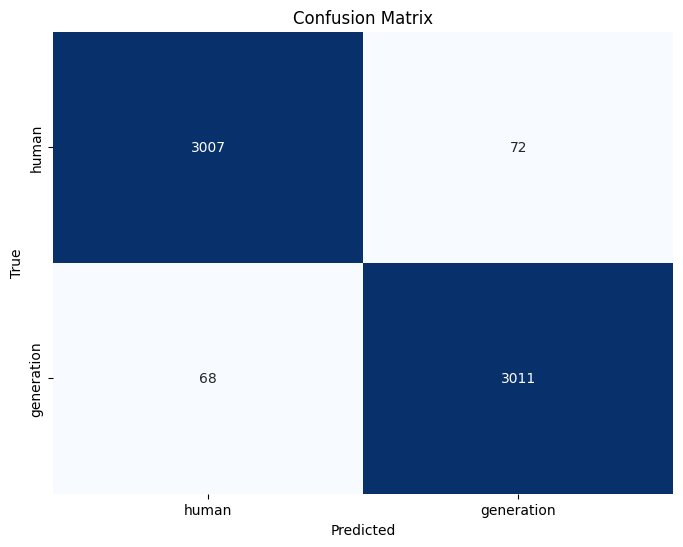

In [13]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'generation'])

In [14]:
# Save the model
joblib.dump(grid_xgb.best_estimator_, '../models/human_vs_generation/xgb_model.pkl')

['../models/human_vs_generation/xgb_model.pkl']

## `Human vs Polish`

In [15]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']


# Keep only human and polish labels
Z_train = train_data[train_data['label'].isin(['human', 'polish'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'polish'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'polish': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'polish': 1})

X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (24632, 38)
y_train shape: (24632,)
X_test shape: (6158, 38)
y_test shape: (6158,)


In [16]:
# Label count
print(y_train.value_counts())

label
0    12316
1    12316
Name: count, dtype: int64


In [17]:
# Instantiate XGBoost classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

In [18]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [650, 700, 750],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.04, 0.05],
    'subsample': [0.8, 0.85],
    'colsample_bytree': [0.75, 0.8]
}

In [19]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:

/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.75, 0.8],
                         'learning_rate': [0.04, 0.05], 'max_depth': [4, 5, 6],
                         'n_estimators': [650, 700, 750],
                         'subsample': [0.8, 0.85]},
             scoring='roc_auc', verbose=1)

In [20]:
print("Best params:", grid_xgb.best_params_)
print("CV best score:", grid_xgb.best_score_)

Best params: {'colsample_bytree': 0.75, 'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.8}
CV best score: 0.8803361176488054


In [21]:
# Evaluate on test set
y_pred = grid_xgb.predict(X_test)
y_proba = grid_xgb.predict_proba(X_test)[:, 1]

In [22]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.7967
AUC: 0.8849


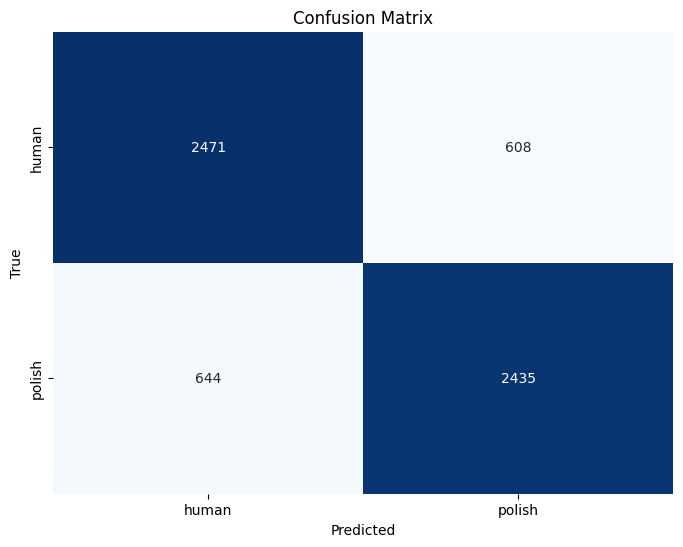

In [23]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'polish'])

In [24]:
# Save the model
joblib.dump(grid_xgb.best_estimator_, '../models/human_vs_polish/xgb_model.pkl')

['../models/human_vs_polish/xgb_model.pkl']

## `Human vs Mix`

In [25]:
# feature matrix X and target y
feature_cols = ['num_characters', 'word_count', 'sentence_count',
                'mean_sentence_length', 'burstiness', 'stop_words_ratio',
                'vocabulary_size', 'ttr', 'tfidf_method', 'tfidf_approach',
                'tfidf_proposed', 'tfidf_paper', 'tfidf_study', 'tfidf_analysis',
                'tfidf_using', 'tfidf_application', 'tfidf_potential',
                'tfidf_performance', 'tfidf_network', 'tfidf_algorithm',
                'tfidf_feature', 'tfidf_learning', 'tfidf_data', 'tfidf_model',
                'tfidf_control', 'tfidf_information', 'tfidf_accuracy',
                'tfidf_technique', 'flesch', 'noun_prop', 'det_prop', 'adj_prop',
                'aux_prop', 'pron_prop', 'adv_prop', 'punct_prop', 'adp_prop', 'ppl']


# Keep only human and mix labels
Z_train = train_data[train_data['label'].isin(['human', 'mix'])].copy()
Z_test = test_data[test_data['label'].isin(['human', 'mix'])].copy()

Z_train['label'] = Z_train['label'].map({'human': 0, 'mix': 1})
Z_test['label'] = Z_test['label'].map({'human': 0, 'mix': 1})

# Split the data into human and mix
train_h = Z_train[Z_train['label'] == 0]
train_f = Z_train[Z_train['label'] == 1]
test_h  = Z_test[Z_test['label']  == 0]
test_f  = Z_test[Z_test['label']  == 1]

# Number of samples in the minority class
n_train = min(len(train_h), len(train_f))
n_test  = min(len(test_h),  len(test_f))

# Undersample the majority class
train_h_down = train_h.sample(n_train, replace=False, random_state=42)
train_f_down = train_f.sample(n_train, replace=False, random_state=42)
test_h_down  = test_h.sample(n_test,  replace=False, random_state=42)
test_f_down  = test_f.sample(n_test,  replace=False, random_state=42)

# Concatenate the undersampled data
Z_train = pd.concat([train_h_down, train_f_down], axis=0)
Z_test  = pd.concat([test_h_down, test_f_down], axis=0)

# feature matrix X and target y
X_train = Z_train[feature_cols]
y_train = Z_train['label']

X_test = Z_test[feature_cols]
y_test = Z_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (7222, 38)
y_train shape: (7222,)
X_test shape: (1806, 38)
y_test shape: (1806,)


In [26]:
# Label count
print(y_train.value_counts()), print(y_test.value_counts())

label
0    3611
1    3611
Name: count, dtype: int64
label
0    903
1    903
Name: count, dtype: int64


(None, None)

In [27]:
# Instantiate XGBoost classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

In [28]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.015, 0.02, 0.025, 0.03],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

In [29]:
# Grid search with 5‑fold CV, optimizing for ROC AUC
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/xgboost/core.py:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.015, 0.02, 0.025, 0.03],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [800, 1000, 1200],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='roc_auc', verbose=1)

In [30]:
print("Best params:", grid_xgb.best_params_)
print("CV best score:", grid_xgb.best_score_)

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.015, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.6}
CV best score: 0.7135586014904808


In [31]:
# Evaluate on test set
y_pred = grid_xgb.predict(X_test)
y_proba = grid_xgb.predict_proba(X_test)[:, 1]

In [32]:
# print Accuracy and AUC
print_metrics(y_test, y_pred, y_proba)

Accuracy: 0.6617
AUC: 0.7226


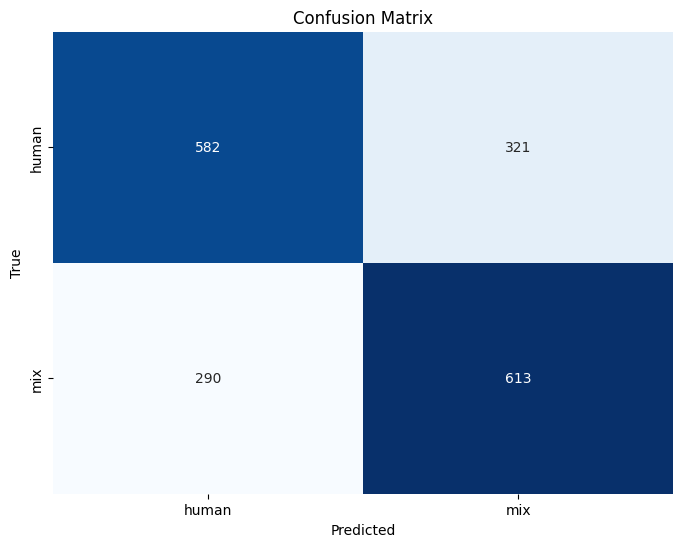

In [33]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['human', 'mix'])

In [34]:
# Save the model
joblib.dump(grid_xgb.best_estimator_, '../models/human_vs_mix/xgb_model.pkl')

['../models/human_vs_mix/xgb_model.pkl']